In [1]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Librerías
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

from sklearn.metrics import mean_absolute_error, mean_squared_error
from typing import Dict, Optional


In [3]:
from google.colab import files
uploaded = files.upload()

Saving facultad.xlsx to facultad.xlsx
Saving Inflacion.xlsx to Inflacion.xlsx


In [4]:
#Cargar y transformar el dataset
df = pd.read_excel("facultad.xlsx")
df["Periodo"] = pd.to_datetime(df["Periodo"])
df_raw = df.sort_values("Periodo")

df_raw['Periodo'] = (df_raw['Periodo'] + pd.offsets.MonthEnd(0)).dt.to_period('M').dt.to_timestamp('M')
df_raw = df_raw.sort_values('Periodo')
df_raw = df_raw[['Periodo','Moneda','Destino','Stage','Sum(DeudaPesif)']].copy()


In [8]:
# Carga el dataset de la inflacion mensual argentina
df_inf = pd.read_excel("Inflacion.xlsx")

# Normaliza Periodo a fin de mes
if 'Periodo' in df_inf.columns:
    df_inf['Periodo'] = pd.to_datetime(df_inf['Periodo'])
    df_inf['Periodo'] = (df_inf['Periodo'] + pd.offsets.MonthEnd(0)).dt.to_period('M').dt.to_timestamp('M')
else:
    raise ValueError("Inflacion.xlsx debe tener una columna 'Periodo'.")

# Detecta columna de inflación (contenga 'infl' o 'ipc')
infl_col = next((c for c in df_inf.columns if 'infl' in str(c).lower() or 'ipc' in str(c).lower()), None)
if infl_col is None:
    num_cols = [c for c in df_inf.columns if c != 'Periodo' and pd.api.types.is_numeric_dtype(df_inf[c])]
    if not num_cols:
        raise ValueError("No se encontró columna numérica de inflación en Inflacion.xlsx.")
    infl_col = num_cols[0]

# Detecta columna RIPTE
ripte_col = next((c for c in df_inf.columns if 'ripte' in str(c).lower()), None)
if ripte_col is None:
    num_cols_r = [c for c in df_inf.columns
                  if c not in ['Periodo', infl_col] and pd.api.types.is_numeric_dtype(df_inf[c])]
    if not num_cols_r:
        raise ValueError("No se encontró columna RIPTE en Inflacion.xlsx.")
    ripte_col = num_cols_r[0]

# Filtra y renombra
df_inf = df_inf[['Periodo', infl_col, ripte_col]].rename(columns={infl_col: 'inflacion', ripte_col: 'ripte'}).copy()
df_inf = df_inf.sort_values('Periodo').drop_duplicates(subset=['Periodo'], keep='last').reset_index(drop=True)

In [9]:
# Filtramos los destinos a analizar.
DESTINOS_SELECCIONADOS = [
    ('Pesos', 'COMERCIAL CAP.DE TRABAJO'),
    ('Pesos', 'COMERCIAL INVERSIONES'),
    ('Pesos', 'INDIVIDUOS PERSONALES'),
    ('Pesos', 'INDIVIDUOS VIVIENDA'),
    ('Pesos', 'INDIVIDUOS TARJETAS'),
    ('Dolares estadounidenses', 'COMERCIAL CAP.DE TRABAJO'),
    ('Dolares estadounidenses', 'COMERCIAL INVERSIONES'),
]

In [10]:
# Filtrar solo con las columnas que interesan
cols = ['Periodo','Moneda','Destino','Stage','Sum(DeudaPesif)']
df_raw = df_raw[cols].copy()

# Crear una máscara para filtrar
mask_destinos = df_raw[['Moneda','Destino']].apply(tuple, axis=1).isin(DESTINOS_SELECCIONADOS)
df_sel = df_raw[mask_destinos].copy()

# Se filtra el DataFrame original con la máscara
total_mes = (
    df_sel.groupby(['Moneda','Destino', pd.Grouper(key='Periodo', freq='M')])['Sum(DeudaPesif)']
         .sum().rename('total_destino').reset_index()
)

# Se calcula el total de deuda por mes, moneda y destino. Luego se agrupa

stage23_mes = (
    df_sel[df_sel['Stage'].isin(['Stage 2','Stage 3'])]
        .groupby(['Moneda','Destino', pd.Grouper(key='Periodo', freq='M')])['Sum(DeudaPesif)']
        .sum().rename('stage23_destino').reset_index()
)

# Se calcula la deuda solo de Stage 2 y Stage 3 por mes, moneda y destino
df_pct = total_mes.merge(stage23_mes, on=['Moneda','Destino','Periodo'], how='left')

df_pct['stage23_destino'] = df_pct['stage23_destino'].fillna(0.0)

# Se calcula el porcentaje que representa la deuda Stage 2-3 sobre el total
df_pct['porcentaje'] = (df_pct['stage23_destino'] / df_pct['total_destino']).replace([np.inf, -np.inf], np.nan)

df_pct = df_pct.sort_values(['Moneda','Destino','Periodo']).reset_index(drop=True)



/tmp/ipython-input-1311534330.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_sel.groupby(['Moneda','Destino', pd.Grouper(key='Periodo', freq='M')])['Sum(DeudaPesif)']
/tmp/ipython-input-1311534330.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby(['Moneda','Destino', pd.Grouper(key='Periodo', freq='M')])['Sum(DeudaPesif)']


In [11]:
# Regresores de calendario: mes como sin/cos (estacionalidad anual)

def month_sin_cos(index: pd.DatetimeIndex) -> np.ndarray:
    m = index.month.values
    return np.vstack([np.sin(2*np.pi*m/12.0), np.cos(2*np.pi*m/12.0)]).T.astype(np.float32)

class MinMaxScaler1D:
    # Escalador simple 1D con protección ante valores no finitos
    def fit(self, x: np.ndarray):
        x = x[np.isfinite(x)]
        self.min_ = float(np.min(x)) if len(x) else 0.0
        self.max_ = float(np.max(x)) if len(x) else 1.0
        self.range_ = self.max_ - self.min_ if self.max_ > self.min_ else 1.0
        return self
    def transform(self, x: np.ndarray):
        return ((x - self.min_) / self.range_).astype(np.float32)
    def inverse_transform(self, x: np.ndarray):
        return (x * self.range_ + self.min_).astype(np.float32)

def align_inflation_to_index(df_infl: pd.DataFrame, index: pd.DatetimeIndex) -> np.ndarray:
    s = df_infl.set_index('Periodo')['inflacion'].sort_index()
    s = s.reindex(index).ffill()
    return s.values.astype(np.float32)

def align_ripte_to_index(df_infl: pd.DataFrame, index: pd.DatetimeIndex) -> np.ndarray:
    s = df_infl.set_index('Periodo')['ripte'].sort_index()
    s = s.reindex(index).ffill()
    return s.values.astype(np.float32)

    # Se convierte una serie y sus regresores en ventanas supervisadas
    # Devuelve arrays listos para el DataModule
def build_windows_with_regs(y: np.ndarray, regs: np.ndarray, idx: pd.DatetimeIndex, lookback: int, horizon: int):
    X, Y, XR, YR, t_idx = [], [], [], [], []
    T = len(y)

    if T < lookback + horizon:
        print(f"[AVISO] Serie demasiado corta (T={T}) para lookback={lookback} y horizon={horizon}")
        return (
            np.empty((0, lookback), dtype=np.float32),
            np.empty((0, horizon), dtype=np.float32),
            np.empty((0, lookback, regs.shape[1]), dtype=np.float32),
            np.empty((0, horizon, regs.shape[1]), dtype=np.float32),
            np.empty((0,), dtype='datetime64[ns]')
        )

    for t in range(lookback, T - horizon + 1):
        if not (np.isfinite(y[t-lookback:t]).all() and np.isfinite(y[t:t+horizon]).all()):
            continue
        X.append(y[t-lookback:t])
        Y.append(y[t:t+horizon])
        XR.append(regs[t-lookback:t, :])
        YR.append(regs[t:t+horizon, :])
        t_idx.append(idx[t])

    return (
        np.array(X, np.float32),
        np.array(Y, np.float32),
        np.array(XR, np.float32),
        np.array(YR, np.float32),
        np.array(t_idx)
    )

In [12]:
## Hiperparámetros principales del modelo y del entrenamiento:

LOOKBACK    = 12
H           = 6
MAX_EPOCHS  = 120
PATIENCE    = 15
BATCH_SIZE  = 64

HIDDEN_DIM  = 64
NUM_LAYERS  = 2
DROPOUT     = 0.1
LR          = 1e-3
NHEAD = 4  # cantidad de cabezas en el mecanismo de atención del Transformer

In [13]:
class TSDataset(Dataset):
    # Dataset con claves estándar para el forecaster
    def __init__(self, X, Y, XR, YR):
        self.X = X; self.Y = Y; self.XR = XR; self.YR = YR
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        x  = torch.tensor(self.X[idx])
        y  = torch.tensor(self.Y[idx])
        xr = torch.tensor(self.XR[idx])
        yr = torch.tensor(self.YR[idx])
        return {'x_demand': x.unsqueeze(-1), 'y_demand': y.unsqueeze(-1),
                'x_regressors': xr, 'y_regressors': yr}

class TSDataModule:
    # Produce DataLoaders de train/val
    def __init__(self, Xtr, Ytr, XRtr, YRtr, Xva, Yva, XRva, YRva, batch_size=64):
        self.train_ds = TSDataset(Xtr, Ytr, XRtr, YRtr)
        self.val_ds   = TSDataset(Xva, Yva, XRva, YRva)
        self.batch_size = batch_size
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)
    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False)


In [14]:
# Clase base para modelos de pronóstico con PyTorch Lightning.
class BaseForecaster(LightningModule):

    def __init__(self, learning_rate: float = 1e-3):
        super().__init__()
        self.save_hyperparameters(logger=False)

    def _common_step(self, batch: Dict[str, torch.Tensor], stage: str):
        x     = batch['x_demand']
        y     = batch['y_demand']
        x_reg = batch.get('x_regressors', None)
        y_reg = batch.get('y_regressors', None)
        y_hat = self(x, x_regressors=x_reg, y_demand=y, y_regressors=y_reg)

# Centraliza el cálculo de métricas (MSE y MAE) y la configuración del optimizador

        mse = F.mse_loss(y_hat, y)
        mae = F.l1_loss(y_hat, y)

        self.log(f'{stage}_mse', mse, prog_bar=True, on_step=False, on_epoch=True)
        self.log(f'{stage}_mae', mae, prog_bar=(stage != 'train'), on_step=False, on_epoch=True)
        return {'loss': mse, 'mse': mse.detach(), 'mae': mae.detach()}

    def training_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> torch.Tensor:
        return self._common_step(batch, 'train')['loss']

    def validation_step(self, batch: Dict[str, torch.Tensor], batch_idx: int):
        return self._common_step(batch, 'val')

    def test_step(self, batch: Dict[str, torch.Tensor], batch_idx: int):
        return self._common_step(batch, 'test')

    def predict_step(self, batch: Dict[str, torch.Tensor], batch_idx: Optional[int] = None, dataloader_idx: int = 0):
        x     = batch['x_demand']
        x_reg = batch.get('x_regressors', None)
        y_reg = batch.get('y_regressors', None)
        return self(x, x_regressors=x_reg, y_demand=None, y_regressors=y_reg)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)


In [15]:
# Modelo de pronóstico basado en LSTM que hereda de BaseForecaster.
class LSTMForecaster(BaseForecaster):
    def __init__(self, input_dim=1, regressor_dim=4, hidden_dim=64,
                 num_layers=2, dropout=0.1, forecast_length=6, learning_rate=1e-3):
        super().__init__(learning_rate=learning_rate)
        self.save_hyperparameters()
        self.lstm = nn.LSTM(input_size=input_dim + regressor_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)
        self.hidden_to_output = nn.Linear(hidden_dim, 1)

    def forward(self, x_demand, x_regressors=None, y_demand=None, y_regressors=None):
        B, L, _ = x_demand.shape
        H = self.hparams.forecast_length
        R = self.hparams.regressor_dim
        if x_regressors is None:
            x_regressors = torch.zeros(B, L, R, device=x_demand.device)
        enc_in = torch.cat([x_demand, x_regressors], dim=-1)
        if y_demand is not None:
            # Teacher forcing: y desplazada una posición (primer paso en cero)
            y_shift = torch.zeros_like(y_demand)
            y_shift[:, 1:, :] = y_demand[:, :-1, :]
            if y_regressors is None:
                y_regressors = torch.zeros(B, H, R, device=x_demand.device)
            dec_in = torch.cat([y_shift, y_regressors], dim=-1)
            seq_in = torch.cat([enc_in, dec_in], dim=1)
            out, _ = self.lstm(seq_in)
            return self.hidden_to_output(out[:, -H:, :])
        # Inferencia: delegamos a predict_step para autoregresivo
        return self.predict_step({'x_demand': x_demand, 'x_regressors': x_regressors, 'y_regressors': y_regressors}, None)

    def predict_step(self, batch, batch_idx=None, dataloader_idx=0):
        # Generación autoregresiva: un paso a la vez, retroalimentando predicción previa
        x = batch['x_demand']; xr = batch.get('x_regressors'); yr = batch.get('y_regressors')
        B, L, _ = x.shape; H = self.hparams.forecast_length; R = self.hparams.regressor_dim
        if xr is None: xr = torch.zeros(B, L, R, device=x.device)
        if yr is None: yr = torch.zeros(B, H, R, device=x.device)
        out, (h, c) = self.lstm(torch.cat([x, xr], dim=-1))
        preds = []; prev_y = x[:, -1:, :]
        for t in range(H):
            step_in = torch.cat([prev_y, yr[:, t:t+1, :]], dim=-1)
            out, (h, c) = self.lstm(step_in, (h, c))
            pred_t = self.hidden_to_output(out)
            preds.append(pred_t); prev_y = pred_t
        return torch.cat(preds, dim=1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type   | Params | Mode 
----------------------------------------------------
0 | lstm             | LSTM   | 51.5 K | train
1 | hidden_to_output | Linear | 65     | train
----------------------------------------------------
51.5 K    Trainable params
0         Non-trainable params
51.5 K    Total params
0.206     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Pesos - COMERCIAL CAP.DE TRABAJO -> MAE_val=0.0019, MSE_val=0.0000


/tmp/ipython-input-3199285985.py:115: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_idx = pd.date_range(last_date + pd.offsets.MonthEnd(1), periods=H, freq='M')


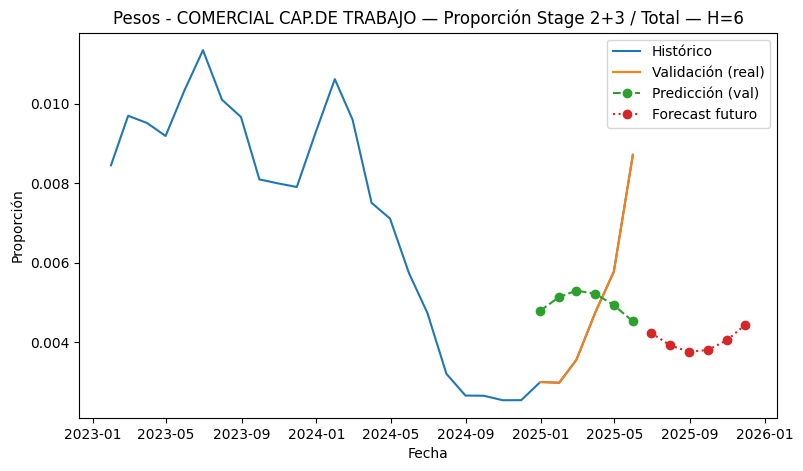

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /mnt/data/lstm_destinos_logs_inflacion/version_2/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type   | Params | Mode 
----------------------------------------------------
0 | lstm             | LSTM   | 51.5 K | train
1 | hidden_to_output | Linear | 65     | train
----------------------------------------------------
51.5 K    Trainable params
0         Non-trainable params
51.5 K    Total params
0.206     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop

Pesos - COMERCIAL INVERSIONES -> MAE_val=0.0050, MSE_val=0.0000


/tmp/ipython-input-3199285985.py:115: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_idx = pd.date_range(last_date + pd.offsets.MonthEnd(1), periods=H, freq='M')


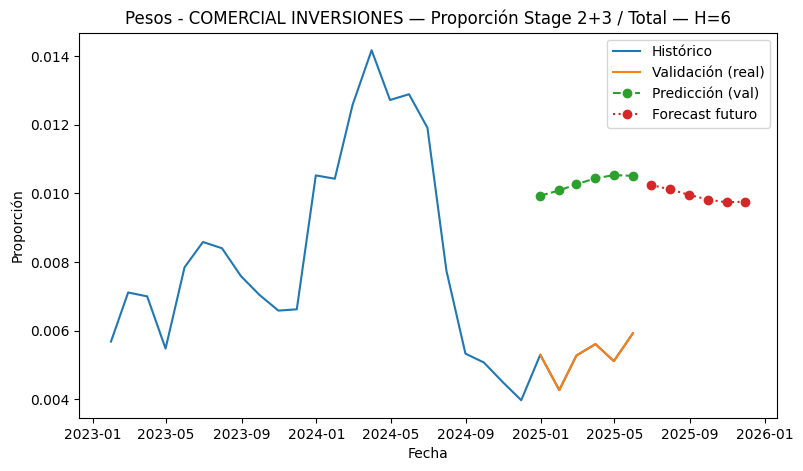

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /mnt/data/lstm_destinos_logs_inflacion/version_2/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type   | Params | Mode 
----------------------------------------------------
0 | lstm             | LSTM   | 51.5 K | train
1 | hidden_to_output | Linear | 65     | train
----------------------------------------------------
51.5 K    Trainable params
0         Non-trainable params
51.5 K    Total params
0.206     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop

Pesos - INDIVIDUOS PERSONALES -> MAE_val=0.0044, MSE_val=0.0000


/tmp/ipython-input-3199285985.py:115: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_idx = pd.date_range(last_date + pd.offsets.MonthEnd(1), periods=H, freq='M')


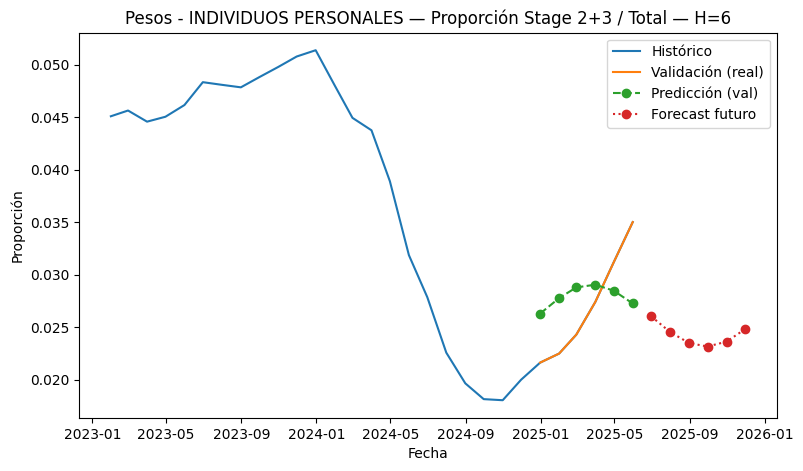

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /mnt/data/lstm_destinos_logs_inflacion/version_2/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type   | Params | Mode 
----------------------------------------------------
0 | lstm             | LSTM   | 51.5 K | train
1 | hidden_to_output | Linear | 65     | train
----------------------------------------------------
51.5 K    Trainable params
0         Non-trainable params
51.5 K    Total params
0.206     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop

Pesos - INDIVIDUOS VIVIENDA -> MAE_val=0.0044, MSE_val=0.0000


/tmp/ipython-input-3199285985.py:115: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_idx = pd.date_range(last_date + pd.offsets.MonthEnd(1), periods=H, freq='M')


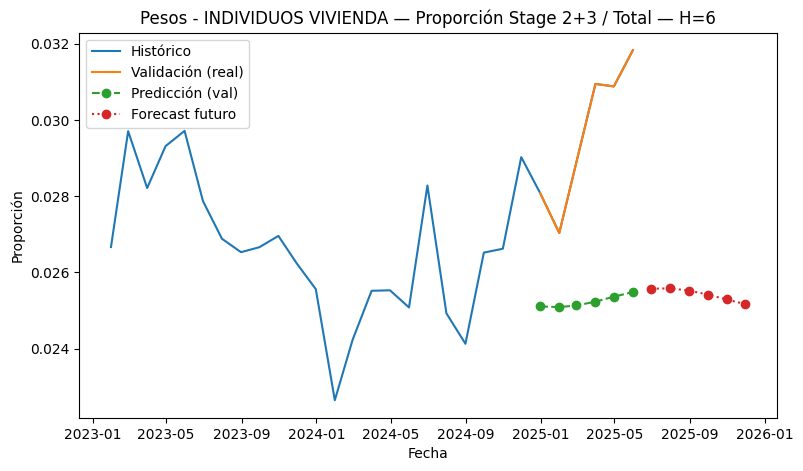

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /mnt/data/lstm_destinos_logs_inflacion/version_2/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type   | Params | Mode 
----------------------------------------------------
0 | lstm             | LSTM   | 51.5 K | train
1 | hidden_to_output | Linear | 65     | train
----------------------------------------------------
51.5 K    Trainable params
0         Non-trainable params
51.5 K    Total params
0.206     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop

Pesos - INDIVIDUOS TARJETAS -> MAE_val=0.0122, MSE_val=0.0002


/tmp/ipython-input-3199285985.py:115: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_idx = pd.date_range(last_date + pd.offsets.MonthEnd(1), periods=H, freq='M')


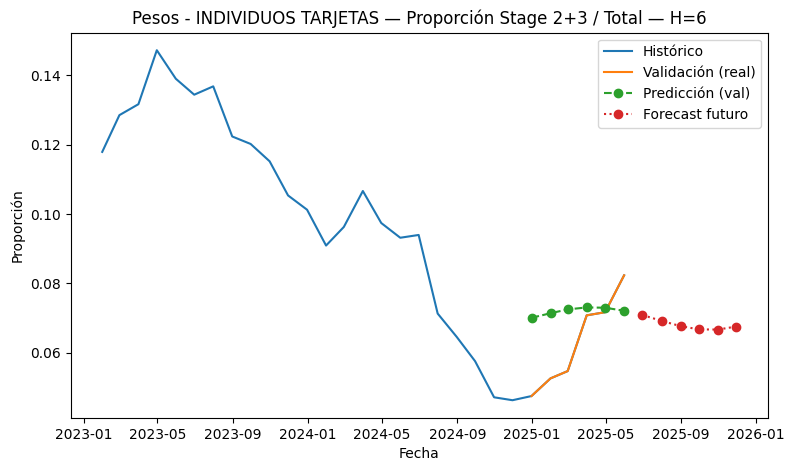

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /mnt/data/lstm_destinos_logs_inflacion/version_2/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type   | Params | Mode 
----------------------------------------------------
0 | lstm             | LSTM   | 51.5 K | train
1 | hidden_to_output | Linear | 65     | train
----------------------------------------------------
51.5 K    Trainable params
0         Non-trainable params
51.5 K    Total params
0.206     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop

Dolares estadounidenses - COMERCIAL CAP.DE TRABAJO -> MAE_val=0.0175, MSE_val=0.0003


/tmp/ipython-input-3199285985.py:115: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_idx = pd.date_range(last_date + pd.offsets.MonthEnd(1), periods=H, freq='M')


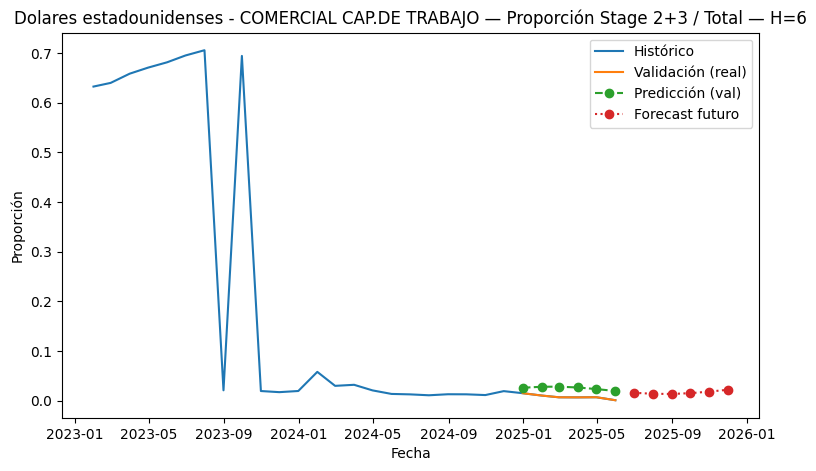

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /mnt/data/lstm_destinos_logs_inflacion/version_2/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type   | Params | Mode 
----------------------------------------------------
0 | lstm             | LSTM   | 51.5 K | train
1 | hidden_to_output | Linear | 65     | train
----------------------------------------------------
51.5 K    Trainable params
0         Non-trainable params
51.5 K    Total params
0.206     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop

Dolares estadounidenses - COMERCIAL INVERSIONES -> MAE_val=0.0210, MSE_val=0.0004


/tmp/ipython-input-3199285985.py:115: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_idx = pd.date_range(last_date + pd.offsets.MonthEnd(1), periods=H, freq='M')


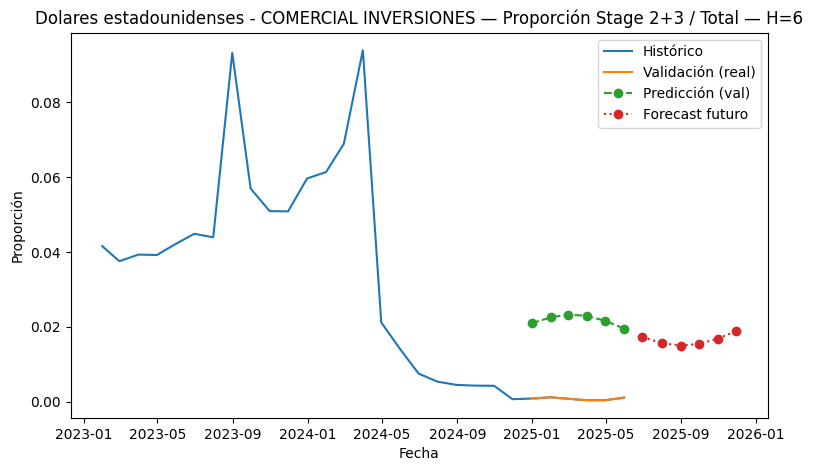

In [18]:
logger = CSVLogger(save_dir='/mnt/data', name='lstm_destinos_logs_inflacion')

results = []     # para MAE/MSE por destino
val_rows = []    # Tabla 1: validación real vs pred
series_rows = [] # Tabla 2: histórico + forecast

# Bucle de entrenamiento, validación y generación de forecast por destino
for (mon, des) in DESTINOS_SELECCIONADOS:
    dsd = df_pct[(df_pct['Moneda'] == mon) & (df_pct['Destino'] == des)].copy()
    if dsd.empty:
        print(f"[AVISO] Sin datos para: ({mon}, {des})."); continue

  # Ordena y deja solo columnas de fecha y porcentaje, con índice = Periodo

    serie = dsd[['Periodo','porcentaje']].dropna().set_index('Periodo').sort_index()
    if len(serie) < LOOKBACK + H + 5:
        print(f"[AVISO] Serie corta para: ({mon}, {des}). len={len(serie)}"); continue

    # Calcula regresores de calendario (mes_sin, mes_cos)
    reg_month = month_sin_cos(serie.index)
    infl_series = align_inflation_to_index(df_inf, serie.index)
    ripte_series = align_ripte_to_index(df_inf, serie.index)

    n = len(serie)
     # Toma 20% para validación
    n_val = max(H, int(n*0.2))
    train_y = serie.iloc[:n-n_val].copy()
    valid_y = serie.iloc[n-n_val:].copy()

    scaler_y = MinMaxScaler1D().fit(train_y['porcentaje'].values)
    scaler_infl = MinMaxScaler1D().fit(infl_series[:len(train_y)])
    scaler_ripte = MinMaxScaler1D().fit(ripte_series[:len(train_y)])


    y_tr = scaler_y.transform(train_y['porcentaje'].values)
    y_va = scaler_y.transform(valid_y['porcentaje'].values)

    #Escala las series de inflación y RIPTE para los periodos de entrenamiento y validación por separado.
    infl_tr = scaler_infl.transform(infl_series[:len(train_y)])
    infl_va = scaler_infl.transform(infl_series[len(train_y):])
    ripte_tr  = scaler_ripte.transform(ripte_series[:len(train_y)])
    ripte_va  = scaler_ripte.transform(ripte_series[len(train_y):])


    reg_tr = np.column_stack([reg_month[:len(train_y)], infl_tr.reshape(-1,1), ripte_tr.reshape(-1,1)])
    reg_va = np.column_stack([reg_month[len(train_y):], infl_va.reshape(-1,1), ripte_va.reshape(-1,1)])

    y_for_valid = np.concatenate([y_tr[-LOOKBACK:], y_va])
    reg_for_valid = np.concatenate([reg_tr[-LOOKBACK:], reg_va])


    #Genera las ventanas de entrada y salida con sus regresores para entrenamiento y validación, y verifica que no estén vacías.
    X_tr, Y_tr, XR_tr, YR_tr, _ = build_windows_with_regs(y_tr, reg_tr, train_y.index, LOOKBACK, H)
    X_va, Y_va, XR_va, YR_va, _ = build_windows_with_regs(
        y_for_valid, reg_for_valid,
        pd.Index([*train_y.index[-LOOKBACK:], *valid_y.index]), LOOKBACK, H
    )
    if len(X_tr) == 0 or len(X_va) == 0:
        print(f"[AVISO] Ventanas vacías para: ({mon}, {des})."); continue

    # Crea el DataModule con los datos preparados
    dm = TSDataModule(X_tr, Y_tr, XR_tr, YR_tr, X_va, Y_va, XR_va, YR_va, batch_size=BATCH_SIZE)
    # Crea el modelo LSTM con hiperparámetros predefinidos
    model = LSTMForecaster(input_dim=1, regressor_dim=4, hidden_dim=HIDDEN_DIM,
                           num_layers=NUM_LAYERS, dropout=DROPOUT,
                           forecast_length=H, learning_rate=LR)


    early = EarlyStopping(monitor='val_mse', mode='min', patience=PATIENCE)
    ckpt  = ModelCheckpoint(monitor='val_mse', mode='min', save_top_k=1)

    # Entrenador Lightning
    trainer = Trainer(max_epochs=MAX_EPOCHS, accelerator='auto', devices=1,
                      logger=logger, callbacks=[early, ckpt], enable_progress_bar=False)
    trainer.fit(model, dm.train_dataloader(), dm.val_dataloader())

    # ----- Comparación validación (primer bloque) -----
    val_loader = dm.val_dataloader()
    batch = next(iter(val_loader))
    model.eval()
    with torch.no_grad():
       # Predice usando teacher forcing
        y_hat = model(batch['x_demand'], batch.get('x_regressors'),
                      batch['y_demand'], batch.get('y_regressors'))

    val_dates = valid_y.index[:H]
    y_true = batch['y_demand'].squeeze(-1).numpy()[0]
    y_pred = y_hat.squeeze(-1).numpy()[0]
    y_true_unscaled = scaler_y.inverse_transform(y_true)
    y_pred_unscaled = scaler_y.inverse_transform(y_pred)

# Métricas MAE y MSE en escala original
    mae_val = mean_absolute_error(y_true_unscaled, y_pred_unscaled)
    mse_val = mean_squared_error(y_true_unscaled, y_pred_unscaled)

    results.append({'Moneda': mon, 'Destino': des, 'MAE_val': mae_val, 'MSE_val': mse_val})
    print(f"{mon} - {des} -> MAE_val={mae_val:.4f}, MSE_val={mse_val:.4f}")

    # Guardar filas tabla 1
    for dt, yr, yp in zip(val_dates, y_true_unscaled, y_pred_unscaled):
        val_rows.append({
            'Moneda': mon,
            'Destino': des,
            'Fecha': dt,
            'Real_valid': float(yr),
            'Pred_valid': float(yp)
        })

    # ----- Forecast futuro H pasos -----
    y_full_scaled = scaler_y.transform(serie['porcentaje'].values)
    context_y  = y_full_scaled[-LOOKBACK:]
    context_rm = reg_month[-LOOKBACK:, :]
    context_in = scaler_infl.transform(infl_series[-LOOKBACK:])
    context_ri = scaler_ripte.transform(ripte_series[-LOOKBACK:])
    context_xr = np.column_stack([context_rm, context_in.reshape(-1,1), context_ri.reshape(-1,1)])

    #Genera las variables de calendario, inflación y RIPTE para los H meses futuros, escalarlas y combinarlas en una matriz de regresores (future_regs).
    last_date = serie.index.max()
    future_idx = pd.date_range(last_date + pd.offsets.MonthEnd(1), periods=H, freq='M')
    future_rm  = month_sin_cos(future_idx)
    infl_future_raw = align_inflation_to_index(df_inf, future_idx)
    infl_future_scaled = scaler_infl.transform(infl_future_raw)
    ripte_future_raw = align_ripte_to_index(df_inf, future_idx)
    ripte_future_scaled = scaler_ripte.transform(ripte_future_raw)
    future_regs = np.column_stack([future_rm, infl_future_scaled.reshape(-1,1), ripte_future_scaled.reshape(-1,1)])

    # Tensores para pasar al modelo en predict_step
    x_batch  = torch.tensor(context_y).unsqueeze(0).unsqueeze(-1)
    xr_batch = torch.tensor(context_xr).unsqueeze(0)
    yr_batch = torch.tensor(future_regs).unsqueeze(0)

    with torch.no_grad():
        preds_scaled = model.predict_step({'x_demand': x_batch,
                                           'x_regressors': xr_batch,
                                           'y_regressors': yr_batch}, None)
    preds_scaled = preds_scaled.squeeze(0).squeeze(-1).cpu().numpy()
    forecast_future = scaler_y.inverse_transform(preds_scaled)

    # ----- Tabla 2: histórico + forecast -----
    for dt, v in zip(serie.index, serie['porcentaje'].values):
        series_rows.append({'Moneda': mon, 'Destino': des, 'Fecha': dt, 'Proporcion': float(v), 'Tipo': 'Historico'})
    for dt, v in zip(future_idx, forecast_future):
        series_rows.append({'Moneda': mon, 'Destino': des, 'Fecha': dt, 'Proporcion': float(v), 'Tipo': 'Forecast'})

    # ----- Gráfico por destino -----
    plt.figure(figsize=(9,5))
    # Histórico
    plt.plot(serie.index, serie['porcentaje'].values, label='Histórico')
    # Validación real
    plt.plot(val_dates, y_true_unscaled, label='Validación (real)')
    # Pred (punteada con puntos)
    plt.plot(val_dates, y_pred_unscaled, linestyle='--', marker='o', label='Predicción (val)')
    # Forecast futuro (punteada con puntos)
    plt.plot(future_idx, forecast_future, linestyle=':', marker='o', label='Forecast futuro')
    plt.title(f'{mon} - {des} — Proporción Stage 2+3 / Total — H={H}')
    plt.xlabel('Fecha'); plt.ylabel('Proporción')
    plt.legend(); plt.show()

# Construir tablas finales
df_validacion = pd.DataFrame(val_rows).sort_values(['Moneda','Destino','Fecha']).reset_index(drop=True)
df_serie_full = pd.DataFrame(series_rows).sort_values(['Moneda','Destino','Fecha','Tipo']).reset_index(drop=True)
df_resultados = pd.DataFrame(results).sort_values(['Moneda','Destino']).reset_index(drop=True)



In [19]:
print("Tabla 3 — Métricas por destino (MAE/MSE):")
display(df_resultados)

Tabla 3 — Métricas por destino (MAE/MSE):


,Moneda,Destino,MAE_val,MSE_val
0,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,0.017506,0.000317
1,Dolares estadounidenses,COMERCIAL INVERSIONES,0.021046,0.000445
2,Pesos,COMERCIAL CAP.DE TRABAJO,0.001862,0.000005
3,Pesos,COMERCIAL INVERSIONES,0.005046,0.000026
4,Pesos,INDIVIDUOS PERSONALES,0.004430,0.000023
5,Pesos,INDIVIDUOS TARJETAS,0.012166,0.000215
6,Pesos,INDIVIDUOS VIVIENDA,0.004377,0.000022


In [20]:
print("Tabla 1 — Comparación Validación (real vs. pred):")
display(df_validacion)



Tabla 1 — Comparación Validación (real vs. pred):


,Moneda,Destino,Fecha,Real_valid,Pred_valid
0,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,2024-12-31,0.014977,0.025967
1,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,2025-01-31,0.010255,0.028000
2,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,2025-02-28,0.006749,0.028161
3,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,2025-03-31,0.006613,0.026481
4,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,2025-04-30,0.006876,0.023309
5,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,2025-05-31,0.000854,0.019441
6,Dolares estadounidenses,COMERCIAL INVERSIONES,2024-12-31,0.000791,0.020919
7,Dolares estadounidenses,COMERCIAL INVERSIONES,2025-01-31,0.001125,0.022496
8,Dolares estadounidenses,COMERCIAL INVERSIONES,2025-02-28,0.000750,0.023247
9,Dolares estadounidenses,COMERCIAL INVERSIONES,2025-03-31,0.000345,0.022936


In [21]:
print("Tabla 2 — Serie completa (histórico + forecast):")
display(df_serie_full)

Tabla 2 — Serie completa (histórico + forecast):


,Moneda,Destino,Fecha,Proporcion,Tipo
0,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,2023-01-31,0.632644,Historico
1,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,2023-02-28,0.640038,Historico
2,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,2023-03-31,0.658590,Historico
3,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,2023-04-30,0.670791,Historico
4,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,2023-05-31,0.681524,Historico
...,...,...,...,...,...
240,Pesos,INDIVIDUOS VIVIENDA,2025-07-31,0.025579,Forecast
241,Pesos,INDIVIDUOS VIVIENDA,2025-08-31,0.025521,Forecast
242,Pesos,INDIVIDUOS VIVIENDA,2025-09-30,0.025415,Forecast
243,Pesos,INDIVIDUOS VIVIENDA,2025-10-31,0.025287,Forecast


# **Modelo Transformer**

In [22]:

class TransformerForecaster(BaseForecaster):
    def __init__(self, input_dim=1, regressor_dim=4, hidden_dim=64, nhead=4,
                 num_layers=2, dropout=0.1, forecast_length=6, learning_rate=1e-3):
        super().__init__(learning_rate=learning_rate)
        self.save_hyperparameters() # Guarda los hiperparámetros automáticamente (útil para reproducibilidad y logging)

# Capa de codificación de Transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=nhead, dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.input_projection = nn.Linear(input_dim + regressor_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, 1) # Capa lineal final para mapear la salida del transformer a un único valor

    def forward(self, x_demand, x_regressors=None, y_demand=None, y_regressors=None):
        B, L, _ = x_demand.shape
        H = self.hparams.forecast_length
        R = self.hparams.regressor_dim

        if x_regressors is None:  # Si no se pasan regresores de entrada, inicializa con ceros
            x_regressors = torch.zeros(B, L, R, device=x_demand.device)
        enc_in = torch.cat([x_demand, x_regressors], dim=-1)  # Une demanda y regresores en la dimensión de features
        enc_in = self.input_projection(enc_in)
        memory = self.encoder(enc_in)

        if y_demand is not None:
            if y_regressors is None:
                y_regressors = torch.zeros(B, H, R, device=x_demand.device)
            y_shift = torch.zeros_like(y_demand)
            y_shift[:, 1:, :] = y_demand[:, :-1, :]
            dec_in = torch.cat([y_shift, y_regressors], dim=-1)
            dec_in = self.input_projection(dec_in)
            out = self.encoder(dec_in)
            return self.decoder(out)

        return self.predict_step({'x_demand': x_demand, 'x_regressors': x_regressors, 'y_regressors': y_regressors}, None)

    def predict_step(self, batch, batch_idx=None, dataloader_idx=0): # Extrae entradas y regresores
        x = batch['x_demand']
        xr = batch.get('x_regressors')
        yr = batch.get('y_regressors')
        B, L, _ = x.shape
        H = self.hparams.forecast_length # longitud del horizonte de predicción
        R = self.hparams.regressor_dim   # cantidad de regresores

        if xr is None:
            xr = torch.zeros(B, L, R, device=x.device)
        if yr is None:
            yr = torch.zeros(B, H, R, device=x.device)

        # Combina demanda y regresores de entrada y proyecta
        enc_in = torch.cat([x, xr], dim=-1)
        enc_in = self.input_projection(enc_in)
        memory = self.encoder(enc_in)

        preds = []
        prev_y = torch.zeros(B, 1, 1, device=x.device)

        # Predicción autoregresiva paso a paso
        for t in range(H):
            dec_in = torch.cat([prev_y, yr[:, t:t+1, :]], dim=-1)
            dec_in = self.input_projection(dec_in)
            out = self.encoder(dec_in)
            pred_t = self.decoder(out)
            preds.append(pred_t)
            prev_y = pred_t
        return torch.cat(preds, dim=1)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type               | Params | Mode 
----------------------------------------------------------------
0 | encoder          | TransformerEncoder | 562 K  | train
1 | input_projection | Linear             | 384    | train
2 | decoder          | Linear             | 65     | train
----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.251     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval 

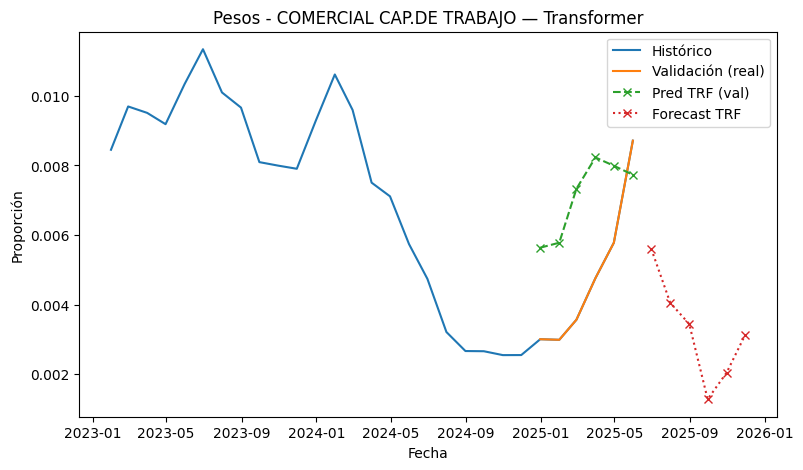

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /mnt/data/trf_inflacion/version_0/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type               | Params | Mode 
----------------------------------------------------------------
0 | encoder          | TransformerEncoder | 562 K  | train
1 | input_projection | Linear             | 384    | train
2 | decoder          | Linear             | 65     | train
----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.251     Total estimated model params size (MB)
24        Modules in train mode

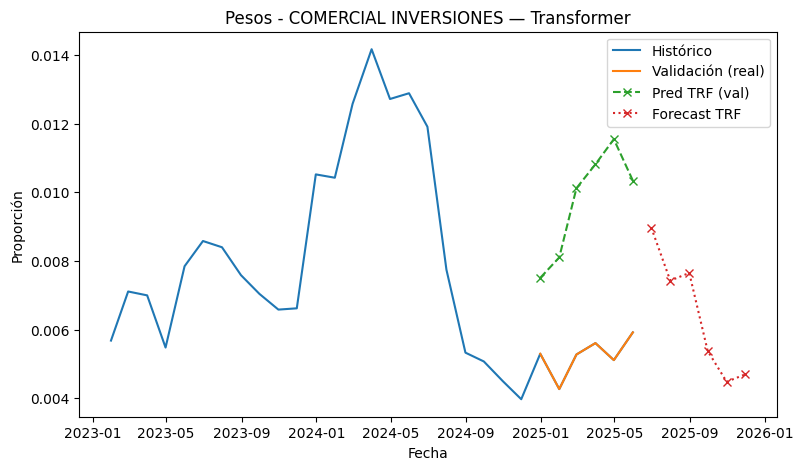

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /mnt/data/trf_inflacion/version_0/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type               | Params | Mode 
----------------------------------------------------------------
0 | encoder          | TransformerEncoder | 562 K  | train
1 | input_projection | Linear             | 384    | train
2 | decoder          | Linear             | 65     | train
----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.251     Total estimated model params size (MB)
24        Modules in train mode

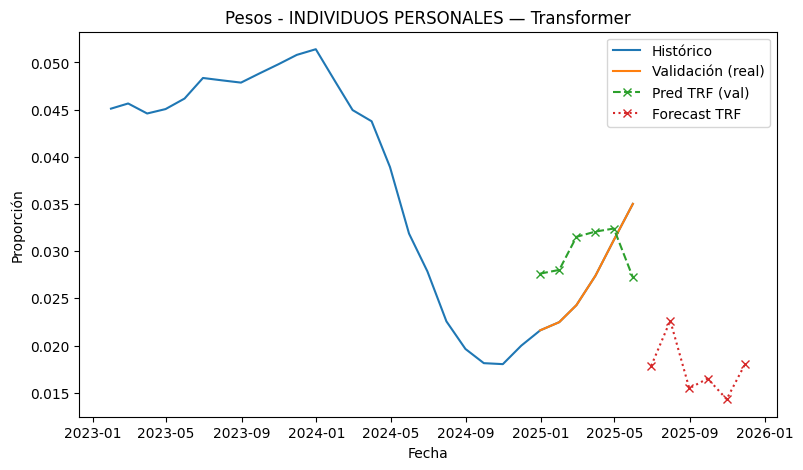

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /mnt/data/trf_inflacion/version_0/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type               | Params | Mode 
----------------------------------------------------------------
0 | encoder          | TransformerEncoder | 562 K  | train
1 | input_projection | Linear             | 384    | train
2 | decoder          | Linear             | 65     | train
----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.251     Total estimated model params size (MB)
24        Modules in train mode

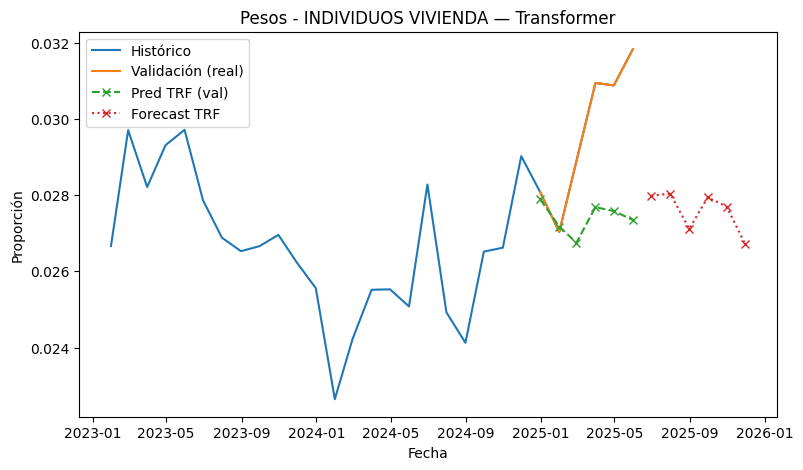

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /mnt/data/trf_inflacion/version_0/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type               | Params | Mode 
----------------------------------------------------------------
0 | encoder          | TransformerEncoder | 562 K  | train
1 | input_projection | Linear             | 384    | train
2 | decoder          | Linear             | 65     | train
----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.251     Total estimated model params size (MB)
24        Modules in train mode

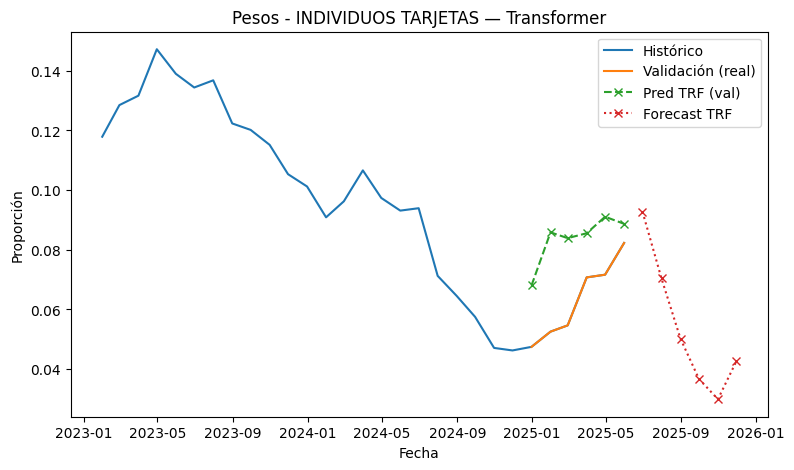

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /mnt/data/trf_inflacion/version_0/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type               | Params | Mode 
----------------------------------------------------------------
0 | encoder          | TransformerEncoder | 562 K  | train
1 | input_projection | Linear             | 384    | train
2 | decoder          | Linear             | 65     | train
----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.251     Total estimated model params size (MB)
24        Modules in train mode

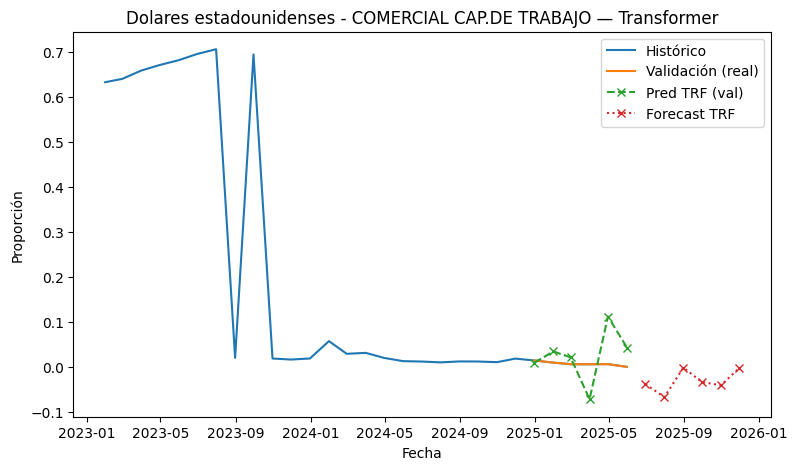

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /mnt/data/trf_inflacion/version_0/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type               | Params | Mode 
----------------------------------------------------------------
0 | encoder          | TransformerEncoder | 562 K  | train
1 | input_projection | Linear             | 384    | train
2 | decoder          | Linear             | 65     | train
----------------------------------------------------------------
562 K     Trainable params
0         Non-trainable params
562 K     Total params
2.251     Total estimated model params size (MB)
24        Modules in train mode

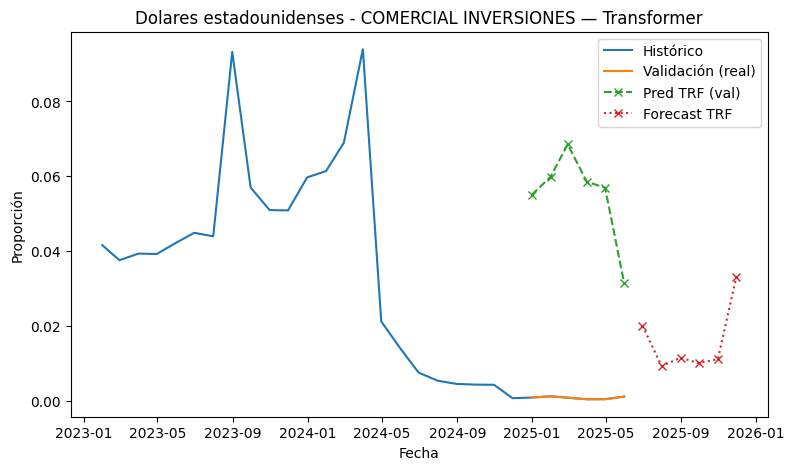

Tabla Transformer — Métricas (MAE/MSE):


,Moneda,Destino,MAE_val,MSE_val
0,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,0.045175,0.003318
1,Dolares estadounidenses,COMERCIAL INVERSIONES,0.054316,0.003082
2,Pesos,COMERCIAL CAP.DE TRABAJO,0.002642,0.000008
3,Pesos,COMERCIAL INVERSIONES,0.004493,0.000022
4,Pesos,INDIVIDUOS PERSONALES,0.005410,0.000034
5,Pesos,INDIVIDUOS TARJETAS,0.020633,0.000504
6,Pesos,INDIVIDUOS VIVIENDA,0.002252,0.000008


Tabla Transformer — Validación (Real vs Pred_TRF):


,Moneda,Destino,Fecha,Real_valid,Pred_TRF
0,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,2024-12-31,0.014977,0.010184
1,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,2025-01-31,0.010255,0.035047
2,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,2025-02-28,0.006749,0.022026
3,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,2025-03-31,0.006613,-0.070975
4,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,2025-04-30,0.006876,0.112591
5,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,2025-05-31,0.000854,0.043741
6,Dolares estadounidenses,COMERCIAL INVERSIONES,2024-12-31,0.000791,0.054977
7,Dolares estadounidenses,COMERCIAL INVERSIONES,2025-01-31,0.001125,0.059821
8,Dolares estadounidenses,COMERCIAL INVERSIONES,2025-02-28,0.000750,0.068543
9,Dolares estadounidenses,COMERCIAL INVERSIONES,2025-03-31,0.000345,0.058571


Tabla Transformer — Serie completa (histórico + forecast):


,Moneda,Destino,Fecha,Proporcion,Tipo
0,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,2023-01-31,0.632644,Historico
1,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,2023-02-28,0.640038,Historico
2,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,2023-03-31,0.658590,Historico
3,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,2023-04-30,0.670791,Historico
4,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,2023-05-31,0.681524,Historico
5,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,2023-06-30,0.695275,Historico
6,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,2023-07-31,0.705859,Historico
7,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,2023-08-31,0.020827,Historico
8,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,2023-09-30,0.694378,Historico
9,Dolares estadounidenses,COMERCIAL CAP.DE TRABAJO,2023-10-31,0.019373,Historico


In [25]:
# Entrenamiento y forecast con TransformerForecaster (incluyendo inflación)

logger_trf = CSVLogger(save_dir='/mnt/data', name='trf_inflacion')

metrics_trf = []
val_trf = []
series_rows_trf = []

for (mon, des) in DESTINOS_SELECCIONADOS:
    dsd = df_pct[(df_pct['Moneda']==mon) & (df_pct['Destino']==des)]
    if dsd.empty:
        print(f"[TRF] Sin datos para {mon}-{des}");
        continue

    # Serie ordenada por fecha con índice mensual
    serie = dsd[['Periodo','porcentaje']].dropna().set_index('Periodo').sort_index()
    if len(serie) < LOOKBACK + H + 5:
        print(f"[TRF] Serie corta para {mon}-{des} (len={len(serie)})")
        continue
    #Regresores: estacionales (mes_sin, mes_cos) + inflación + ripte alineada al índice
    reg_month = month_sin_cos(serie.index)
    infl_vals = align_inflation_to_index(df_inf, serie.index)
    ripte_vals = align_ripte_to_index(df_inf, serie.index)

    #Split train/valid (valid ~ 20% o al menos H) ---
    n = len(serie); n_val = max(H, int(n*0.2))
    train_y = serie.iloc[:n-n_val]; valid_y = serie.iloc[n-n_val:]

    sc_y = MinMaxScaler1D().fit(train_y['porcentaje'].values)
    sc_in = MinMaxScaler1D().fit(infl_vals[:len(train_y)])
    sc_ri = MinMaxScaler1D().fit(ripte_vals[:len(train_y)])

    y_tr = sc_y.transform(train_y['porcentaje'].values)
    y_va = sc_y.transform(valid_y['porcentaje'].values)
    in_tr = sc_in.transform(infl_vals[:len(train_y)])
    in_va = sc_in.transform(infl_vals[len(train_y):])
    ri_tr = sc_ri.transform(ripte_vals[:len(train_y)])
    ri_va = sc_ri.transform(ripte_vals[len(train_y):])


    # Matrices de regresores
    reg_tr = np.column_stack([reg_month[:len(train_y)], in_tr.reshape(-1,1), ri_tr.reshape(-1,1)])
    reg_va = np.column_stack([reg_month[len(train_y):], in_va.reshape(-1,1), ri_va.reshape(-1,1)])

    y_for_valid   = np.concatenate([y_tr[-LOOKBACK:],  y_va])
    reg_for_valid = np.vstack([reg_tr[-LOOKBACK:], reg_va])


    # Armado de ventanas para entrenamiento
    X_tr, Y_tr, XR_tr, YR_tr, _ = build_windows_with_regs(y_tr, reg_tr, train_y.index, LOOKBACK, H)

    # Validación: necesitamos concatenar los últimos LOOKBACK índices de entrenamiento + los de validación
    if len(train_y) < LOOKBACK:
      print(f"[TRF] train_y demasiado corto para {mon}-{des}, len={len(train_y)}")
      continue

    idx_valid = pd.Index([*train_y.index[-LOOKBACK:], *valid_y.index])
    X_va, Y_va, XR_va, YR_va, _ = build_windows_with_regs(y_for_valid, reg_for_valid, idx_valid, LOOKBACK, H)

    # Control adicional por si alguna ventana queda vacía
    if len(X_tr) == 0 or len(X_va) == 0:
      print(f"[TRF] Ventanas vacías para {mon}-{des}");
      continue
    #DataModule + Modelo
    dm = TSDataModule(X_tr, Y_tr, XR_tr, YR_tr, X_va, Y_va, XR_va, YR_va, batch_size=BATCH_SIZE)
    model = TransformerForecaster(input_dim=1, regressor_dim=4, hidden_dim=HIDDEN_DIM, nhead=NHEAD,
                                  num_layers=NUM_LAYERS, dropout=DROPOUT, forecast_length=H, learning_rate=LR)


    # Entrenamiento con early stopping y checkpoint por val_mse
    trainer = Trainer(max_epochs=MAX_EPOCHS, accelerator='auto', devices=1,
                      logger=logger_trf, callbacks=[EarlyStopping(monitor='val_mse', patience=PATIENCE),
                                                    ModelCheckpoint(monitor='val_mse')],
                      enable_progress_bar=False)
    trainer.fit(model, dm.train_dataloader(), dm.val_dataloader())

     # Validación: predicción del primer batch de validación
    batch = next(iter(dm.val_dataloader()))
    with torch.no_grad():
        yhat = model(batch['x_demand'], batch['x_regressors'], batch['y_demand'], batch['y_regressors'])
    val_dates = valid_y.index[:H]
    y_true = sc_y.inverse_transform(batch['y_demand'].squeeze(-1).numpy()[0])
    y_pred = sc_y.inverse_transform(yhat.squeeze(-1).numpy()[0])

    # Métricas por destino
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    metrics_trf.append({'Moneda':mon,'Destino':des,'MAE_val':mae,'MSE_val':mse})

    for dt, yr, yp in zip(val_dates, y_true, y_pred):
        val_trf.append({'Moneda':mon,'Destino':des,'Fecha':dt,'Real_valid':float(yr),'Pred_TRF':float(yp)})

    # Forecast futuro (Transformer)
    context_y = sc_y.transform(serie['porcentaje'].values[-LOOKBACK:])
    context_xr = np.column_stack([
        reg_month[-LOOKBACK:],
        infl_vals[-LOOKBACK:].reshape(-1,1),
        ripte_vals[-LOOKBACK:].reshape(-1,1)
    ])
    future_idx = pd.date_range(serie.index.max() + pd.offsets.MonthEnd(1), periods=H, freq='M')

    # Regresores futuros: estacionales del futuro + inflación futura alineada
    future_regs = month_sin_cos(future_idx)
    future_infl = align_inflation_to_index(df_inf, future_idx)
    future_infl = sc_in.transform(future_infl)
    future_ri   = align_ripte_to_index(df_inf, future_idx)
    future_ri   = sc_ri.transform(future_ri)
    future_xr   = np.column_stack([future_regs, future_infl.reshape(-1,1), future_ri.reshape(-1,1)])

    # Tensores para el modelo
    x_batch  = torch.tensor(context_y).unsqueeze(0).unsqueeze(-1).float()
    xr_batch = torch.tensor(context_xr).unsqueeze(0).float()
    yr_batch = torch.tensor(future_xr).unsqueeze(0).float()

    with torch.no_grad():
        forecast = model.predict_step({'x_demand': x_batch,
                                       'x_regressors': xr_batch,
                                       'y_regressors': yr_batch}, None)

    forecast = forecast.squeeze(0).squeeze(-1).cpu().numpy()
    forecast_unscaled = sc_y.inverse_transform(forecast)

    # Guardar histórico + forecast
    for dt, v in zip(serie.index, serie['porcentaje'].values):
        series_rows_trf.append({'Moneda': mon, 'Destino': des, 'Fecha': dt, 'Proporcion': float(v), 'Tipo': 'Historico'})
    for dt, v in zip(future_idx, forecast_unscaled):
        series_rows_trf.append({'Moneda': mon, 'Destino': des, 'Fecha': dt, 'Proporcion': float(v), 'Tipo': 'Forecast'})

    # Gráfico por destino
    plt.figure(figsize=(9,5))
    plt.plot(serie.index, serie['porcentaje'].values, label='Histórico')
    plt.plot(val_dates, y_true, label='Validación (real)')
    plt.plot(val_dates, y_pred, linestyle='--', marker='x', label='Pred TRF (val)')
    plt.plot(future_idx, forecast_unscaled, linestyle=':', marker='x', label='Forecast TRF')
    plt.title(f'{mon} - {des} — Transformer')
    plt.xlabel('Fecha'); plt.ylabel('Proporción'); plt.legend(); plt.show()

df_metrics_trf = pd.DataFrame(metrics_trf).sort_values(['Moneda','Destino']).reset_index(drop=True)
df_val_trf     = pd.DataFrame(val_trf).sort_values(['Moneda','Destino','Fecha']).reset_index(drop=True)
df_full_trf    = pd.DataFrame(series_rows_trf).sort_values(['Moneda','Destino','Fecha']).reset_index(drop=True)

print("Tabla Transformer — Métricas (MAE/MSE):")
display(df_metrics_trf)
print("Tabla Transformer — Validación (Real vs Pred_TRF):")
display(df_val_trf.head(30))
print("Tabla Transformer — Serie completa (histórico + forecast):")
display(df_full_trf.head(30))